In [2]:
import sys
if sys.version_info[0] < 3:
   raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io
if __name__ == "__main__":
    for data_name in ["mnist", "spam", "toy"]:
       data = np.load(f"data/{data_name}-data.npz")
       print("\nloaded %s data!" % data_name)
       fields = "test_data", "training_data", "training_labels"
       for field in fields:
          print(field, data[field].shape)


loaded mnist data!
test_data (10000, 1, 28, 28)
training_data (60000, 1, 28, 28)
training_labels (60000,)

loaded spam data!
test_data (1000, 43)
training_data (4171, 43)
training_labels (4171,)

loaded toy data!
test_data (0,)
training_data (1000, 2)
training_labels (1000,)


## 2.e Toys

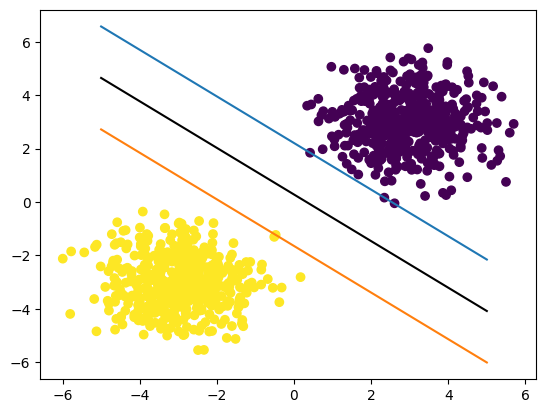

In [7]:
toy = np.load("data/toy-data.npz")

toy_train_data = toy["training_data"]
toy_train_labels = toy["training_labels"]
w = [-0.4528, -0.5190]
alpha = 0.1471

# Plot the points
plt.scatter(toy_train_data[:, 0], toy_train_data[:, 1], c=toy_train_labels)

# Plot decision boundary
x = np.linspace(-5, 5, 100)
y = -(w[0] * x + alpha) / w[1]  # rearranged from w[0]*x1 + w[1]*x2 + alpha
plt.plot(x, y, "k")

# Plot margins
y_margin_lower = -((w[0] * x + alpha) - 1) / w[1]
y_margin_upper = -((w[0] * x + alpha) + 1) / w[1]
plt.plot(x, y_margin_upper)
plt.plot(x, y_margin_lower)
plt.show()

\pagebreak

## 3. Data Partition

In [26]:
np.random.seed(15)

"""Shuffles and partitions data"""


def partition(data, labels, validation_size):
    total_size = len(data)
    # in the case where a percentage is given
    if validation_size < 1:
        validation_size = int(validation_size * total_size)
    shuffled_ind = np.random.permutation(total_size)

    # uses fancy indexing, first reshuffling data, then getting the validation set
    val_data = data[shuffled_ind][:validation_size]
    val_label = labels[shuffled_ind][:validation_size]
    train_data = data[shuffled_ind][validation_size:]
    train_label = labels[shuffled_ind][validation_size:]

    return train_data, train_label, val_data, val_label


def eval_metric(y_pred, y_hat):
    assert len(y_pred) == len(y_hat)
    total_pred = len(y_pred)
    correct_pred = np.sum(y_pred == y_hat)  # vectorized, easier than for loop
    return correct_pred / total_pred

In [27]:
mnist = np.load(f"data/mnist-data.npz")
spam = np.load(f"data/spam-data.npz")

mnist_train_data_flat = mnist["training_data"].reshape(
    mnist["training_data"].shape[0], -1
)

minst_train_d, minst_train_l, minst_val_d, minst_val_l = partition(
    mnist_train_data_flat, mnist["training_labels"], 10000
)
spam_train_d, spam_train_l, spam_val_d, spam_val_l = partition(
    spam["training_data"], spam["training_labels"], 0.2
)

print(
    len(minst_train_l),
    len(minst_val_l),
    len(minst_val_d),
    len(spam_train_l),
    len(spam_train_d),
    len(spam_val_l),
)

50000 10000 10000 3337 3337 834


\pagebreak

## 4. Support Vector Machines 

In [16]:
def svm_model(data, training_sizes, train_data, train_label, val_data, val_label):
    # store accuracies across diff training sizes
    train_accuracies = []
    val_accuracies = []
    for size in training_sizes:
        # Train model
        model = svm.SVC(kernel="linear")
        model.fit(train_data[:size], train_label[:size])

        # Predict training accuracy
        train_pred = model.predict(train_data[:size])
        train_accuracy = eval_metric(train_pred, train_label[:size])
        train_accuracies.append(train_accuracy)

        # Predict validation accuracy
        val_pred = model.predict(val_data[:size])
        val_accuracy = eval_metric(val_pred, val_label[:size])
        val_accuracies.append(val_accuracy)
    plot_ex_accuracies(data, training_sizes, train_accuracies, val_accuracies)


def plot_ex_accuracies(data, training_sizes, train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(training_sizes, train_accuracies, label="Training Accuracies")
    plt.plot(training_sizes, val_accuracies, label="Validation Accuracies")
    plt.title(data)
    plt.xlabel("Number of Examples")
    plt.ylabel("Accuracy")
    plt.legend()

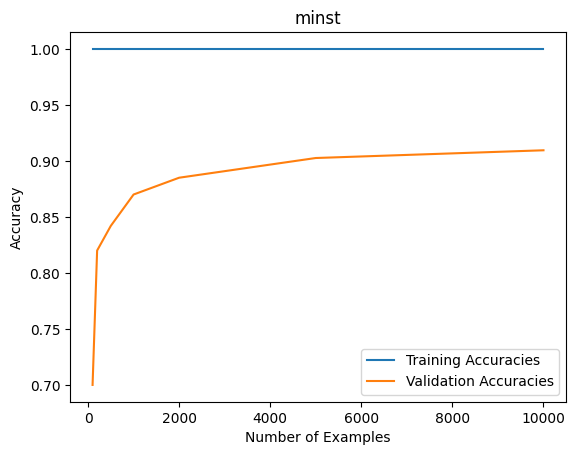

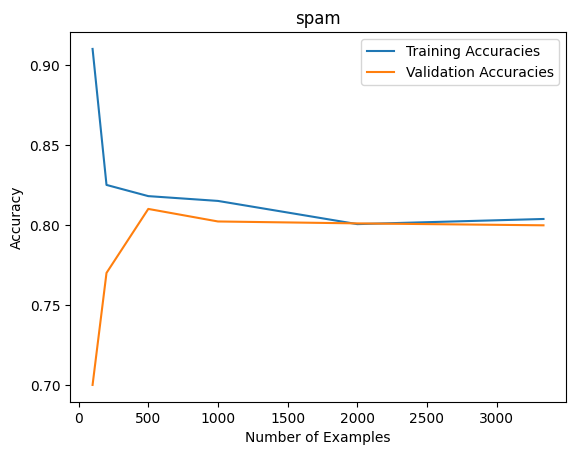

In [46]:
m_train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]
s_train_sizes = [100, 200, 500, 1000, 2000, spam_train_d.shape[0]]

# print("loaded mnist data!")
# fields = "test_data", "training_data", "training_labels"
# for field in fields:
#     print(field, mnist[field].shape)

# print(mnist_train_data_flat.shape)


svm_model(
    "minst", m_train_sizes, minst_train_d, minst_train_l, minst_val_d, minst_val_l
)
svm_model("spam", s_train_sizes, spam_train_d, spam_train_l, spam_val_d, spam_val_l)

\pagebreak

## 5. Hyperparameter Tuning

I tried these C values [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1], the corresponding accuracy was 1e-08 :  0.8883
1e-07 :  0.9222 <br> 
1e-06 :  0.9298 <br> 
1e-05 :  0.918 <br> 
0.0001 :  0.9095 <br> 
0.001 :  0.9095 <br> 
0.01 :  0.9095 <br> 
0.05 :  0.9095 <br> 
0.1 :  0.9095 <br> 
1 :  0.9095 <br> 
The optimal value for C is 1e-06, with an acurracy of 0.9298

In [17]:
# Testing different C values
def hyper_training(train_size, train_data, train_label, val_data, val_label, c_values):
    val_accuracies = []

    for c in c_values:
        # Train model
        hyper_model = svm.SVC(kernel="linear", C=c)
        hyper_model.fit(train_data[:train_size], train_label[:train_size])

        # Predict validation accuracy
        val_pred = hyper_model.predict(val_data)
        val_accuracy = eval_metric(val_pred, val_label)
        val_accuracies.append((c, val_accuracy))
        print(f"C={c}: Cross-validation accuracy = {val_accuracy}")
    # print(val_accuracies)

In [67]:
hyper_training(
    10000,
    minst_train_d,
    minst_train_l,
    minst_val_d,
    minst_val_l,
    [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1]
)

1e-08 :  0.8883
1e-07 :  0.9222
1e-06 :  0.9298
1e-05 :  0.918
0.0001 :  0.9095
0.001 :  0.9095
0.01 :  0.9095
0.05 :  0.9095
0.1 :  0.9095
1 :  0.9095


\pagebreak

## 6. K-fold cross validation

I tried the C values listbed below and these were the accuracies, the best C value is 10 in my case <br>
C=1e-05: Cross-validation accuracy = 0.7123028762618647 <br>
C=0.0001: Cross-validation accuracy = 0.7168577952009649 <br>
C=0.001: Cross-validation accuracy = 0.7487428021654533 <br>
C=0.01: Cross-validation accuracy = 0.7753540401211965 <br>
C=0.05: Cross-validation accuracy = 0.791898217952584 <br>
C=0.1: Cross-validation accuracy = 0.7926170680222289 <br>
C=1: Cross-validation accuracy = 0.8005293011100102 <br>
C=10: Cross-validation accuracy = 0.8036456583236407 <br>
C=50: Cross-validation accuracy = 0.8029265210586022 <br>
C=100: Cross-validation accuracy = 0.8034061373655568 <br>

In [18]:
def k_fold_cross_validation(train_data, train_label, c_values, k=5):
    total_size = len(train_data)
    shuffled_ind = np.random.permutation(total_size)

    fold_size = total_size // k
    C_accuracies = []

    for c in c_values:
        fold_accuracies = []
        for fold in range(k):
            # indices for val set
            start, end = (
                fold * fold_size,
                (fold + 1) * fold_size if fold < k - 1 else total_size,
            )

            # val, training indices
            val_indices = shuffled_ind[start:end]
            train_indices = np.concatenate((shuffled_ind[:start], shuffled_ind[end:]))

            # slice data
            train_fold_data, train_fold_label = (
                train_data[train_indices],
                train_label[train_indices],
            )
            val_fold_data, val_fold_label = (
                train_data[val_indices],
                train_label[val_indices],
            )

            k_fold_model = svm.SVC(kernel="linear", C=c)
            k_fold_model.fit(train_fold_data, train_fold_label)
            val_predict = k_fold_model.predict(val_fold_data)
            val_accuracy = eval_metric(val_predict, val_fold_label)
            fold_accuracies.append(val_accuracy)
        avg_accuracy = np.mean(fold_accuracies)
        C_accuracies.append((c, avg_accuracy))
        print(f"C={c}: Cross-validation accuracy = {avg_accuracy}")

    C_accuracies.sort(
        key=lambda x: x[1], reverse=True
    )  # sort by descending avg_accuracy
    return C_accuracies

In [7]:
spam = np.load(f"data/spam-data.npz")

k_fold_cross_validation(
    spam["training_data"],
    spam["training_labels"],
    [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1, 10, 50, 100],
)

C=1e-05: Cross-validation accuracy = 0.7123028762618647
C=0.0001: Cross-validation accuracy = 0.7168577952009649
C=0.001: Cross-validation accuracy = 0.7487428021654533
C=0.01: Cross-validation accuracy = 0.7753540401211965
C=0.05: Cross-validation accuracy = 0.791898217952584
C=0.1: Cross-validation accuracy = 0.7926170680222289
C=1: Cross-validation accuracy = 0.8005293011100102
C=10: Cross-validation accuracy = 0.8036456583236407
C=50: Cross-validation accuracy = 0.8029265210586022
C=100: Cross-validation accuracy = 0.8034061373655568
C=1000: Cross-validation accuracy = 0.8036459455190339


[(1000, 0.8036459455190339),
 (10, 0.8036456583236407),
 (100, 0.8034061373655568),
 (50, 0.8029265210586022),
 (1, 0.8005293011100102),
 (0.1, 0.7926170680222289),
 (0.05, 0.791898217952584),
 (0.01, 0.7753540401211965),
 (0.001, 0.7487428021654533),
 (0.0001, 0.7168577952009649),
 (1e-05, 0.7123028762618647)]

\pagebreak

## Question 7: Kaggle Submissions

My submission on Kaggle had a score of Mnist: 0.978, and Spam: 0.84. For both datasets, I wrote a function that finds the best model and hyperparameters for me, experiementing on different kernels: poly, rbf; different values of C, different values of gamma and so on. By sorting though this I was able to find models for mnist that worked really well using "poly", C = 0.000001, gamma = 0.01. However, there doesn't seem to be too much of an improvement in Spam, especially since k-fold modeling wasn't available (can only submit 1 model). So for Spam, I read through some of the emails and experimented with adding features such as "credit", "$", "offer", and used my general intuition on spam/ham emails to add even more features like "click", "urgent". By adding suich features and tuning hyperparameters and using rbf, I was able to achieve a 84% score for spam.

In [32]:
def find_best_model(dataset, train_data, train_label, val_data, val_label, c):
    val_accuracies = []
    gammas = [0.001, 0.01, 0.1]
    kernels = ["poly", "rbf"]
    for kernel in kernels:
        for gamma in gammas:
            val_accuracy = train_model(
                dataset,
                train_data,
                train_label,
                val_data,
                val_label,
                kernel,
                c,
                gamma,
            )
            val_accuracies.append((val_accuracy, kernel, c, gamma))
            print(f"Accuracy: {val_accuracy}, kernel: {kernel}, C={c}, gamma: {gamma}")
    return val_accuracies.sort(key=lambda x: x[1], reverse=True)


def train_model(
    dataset, train_data, train_label, val_data, val_label, kernel, c, gamma
):
    # if dataset == "spam":
    #     accuracy = k_fold_cross_validation(kernel, c, gamma, train_data, train_label)
    #     return accuracy
    # else:
        model = svm.SVC(kernel=kernel, C=c, gamma=gamma)
        model = model.fit(train_data, train_label)
        val_predict = model.predict(val_data)
        val_accuracy = eval_metric(val_predict, val_label)
        return val_accuracy


# def k_fold_cross_validation(kernel, c, gamma, train_data, train_label, k=5):
#     total_size = len(train_data)
#     shuffled_ind = np.random.permutation(total_size)

#     fold_size = total_size // k

#     fold_accuracies = []
#     for fold in range(k):
#         # indices for val set
#         start, end = (
#             fold * fold_size,
#             (fold + 1) * fold_size if fold < k - 1 else total_size,
#         )

#         # val, training indices
#         val_indices = shuffled_ind[start:end]
#         train_indices = np.concatenate((shuffled_ind[:start], shuffled_ind[end:]))

#         # slice data
#         train_fold_data, train_fold_label = (
#             train_data[train_indices],
#             train_label[train_indices],
#         )
#         val_fold_data, val_fold_label = (
#             train_data[val_indices],
#             train_label[val_indices],
#         )

#         k_fold_model = svm.SVC(kernel=kernel, C=c, gamma=gamma)
#         k_fold_model.fit(train_data, train_label)
#         val_predict = k_fold_model.predict(val_fold_data)
#         val_accuracy = eval_metric(val_predict, val_fold_label)
#         fold_accuracies.append(val_accuracy)
#     avg_accuracy = np.mean(fold_accuracies)
#     return avg_accuracy

In [35]:
mnist = np.load(f"data/mnist-data.npz")
spam = np.load(f"data/spam-data.npz")

mnist_train_data_flat = mnist["training_data"].reshape(
    mnist["training_data"].shape[0], -1
)

mnist_train_d, mnist_train_l, mnist_val_d, mnist_val_l = partition(
    mnist_train_data_flat, mnist["training_labels"], 10000
)
spam_train_d, spam_train_l, spam_val_d, spam_val_l = partition(
    spam["training_data"], spam["training_labels"], 0.2
)

In [36]:
find_best_model(
    "spam", spam_train_d, spam_train_l, spam_val_d, spam_val_l, 10
)  # Accuracy: 0.8759328855751498, kernel: rbf, C=10, gamma: 0.1

Accuracy: 0.6990407673860911, kernel: poly, C=10, gamma: 0.001
Accuracy: 0.7278177458033573, kernel: poly, C=10, gamma: 0.01
Accuracy: 0.7649880095923262, kernel: poly, C=10, gamma: 0.1
Accuracy: 0.7685851318944844, kernel: rbf, C=10, gamma: 0.001
Accuracy: 0.8321342925659473, kernel: rbf, C=10, gamma: 0.01
Accuracy: 0.841726618705036, kernel: rbf, C=10, gamma: 0.1


In [20]:
find_best_model(
    "minst", mnist_train_d, mnist_train_l, mnist_val_d, mnist_val_l, 0.000001
)  # Accuracy: 0.9789, kernel: poly, C=1e-06, gamma: 0.01

Accuracy: 0.9775, kernel: poly, C=1e-06, gamma: 0.001
Accuracy: 0.9775, kernel: poly, C=1e-06, gamma: 0.01
Accuracy: 0.9775, kernel: poly, C=1e-06, gamma: 0.1


### Kaggle

In [39]:
import pandas as pd


def kaggle_submit(dataset, train_data, train_labels, test_data, kernel, c, gamma):
    model = svm.SVC(kernel=kernel, C=c, gamma=gamma)
    model.fit(train_data, train_labels)
    if dataset == "mnist":
        test_data = test_data.reshape(test_data.shape[0], -1)

    test_labels = model.predict(test_data)

    test_labels = test_labels.astype(int)
    df = pd.DataFrame({"Category": test_labels})
    df.index += 1
    df.to_csv(f"{dataset}_predictions.csv", index_label="Id")

In [40]:
kaggle_submit("spam", spam_train_d, spam_train_l, spam["test_data"], "rbf", 10, 0.1)
# kaggle_submit(
#     "mnist", mnist_train_d, mnist_train_l, mnist["test_data"], "poly", 0.000001, 0.01
# )